# Statistical Modeling for AlphaCare Insurance Solutions (ACIS)

This notebook performs statistical modeling on the insurance claim data to predict TotalPremium and analyze feature importance.

In [45]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Define the path to the src directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, src_dir)

if 'data_loader' in sys.modules:
    del sys.modules['data_loader']
if 'statistical_modeling' in sys.modules:
    del sys.modules['statistical_modeling']

from data_loader import DataLoader
from statistical_modeling import StatisticalModeling

# Load data
data_loader = DataLoader('../resources/Data/machineLearning.txt')
data = data_loader.load_data()

e:\Studies\tenx\w3\src\data_loader.py:15: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(self.file_path, sep='|')
e:\Studies\tenx\w3\src\data_loader.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])
e:\Studies\tenx\w3\src\data_loader.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_columns] = categorical_imputer.fit_transform(df[cat

Dataset shape: (1000098, 51)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 51 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  float64
 1   PolicyID                  1000098 non-null  float64
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      1000098 non-null  object 
 9   AccountType               1000098 non-null  object 
 10  MaritalStatus             1000098 non-null  object 
 11  Gender                    1000098 non-null  object 
 12  Country                   1000098 non-nu

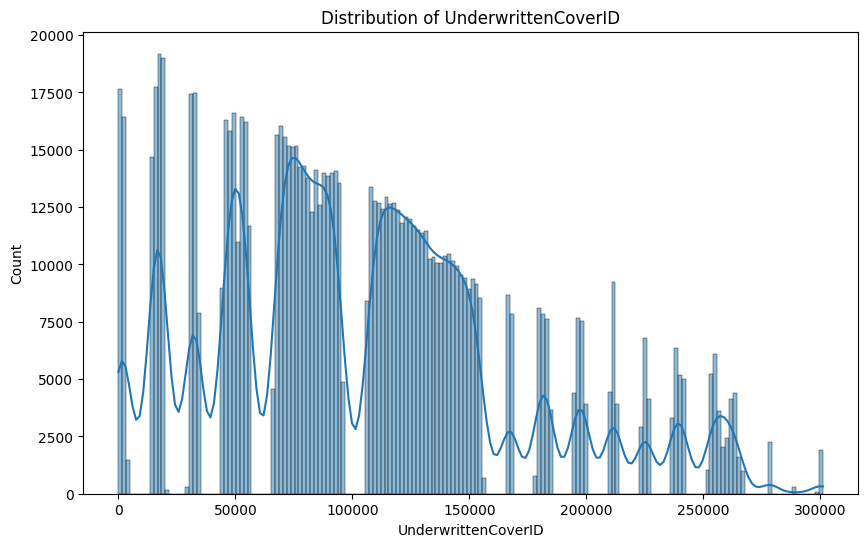

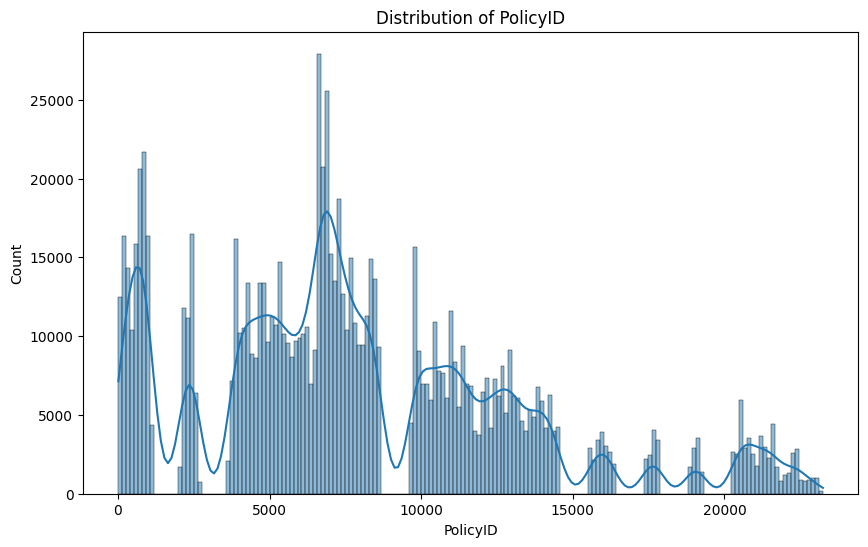

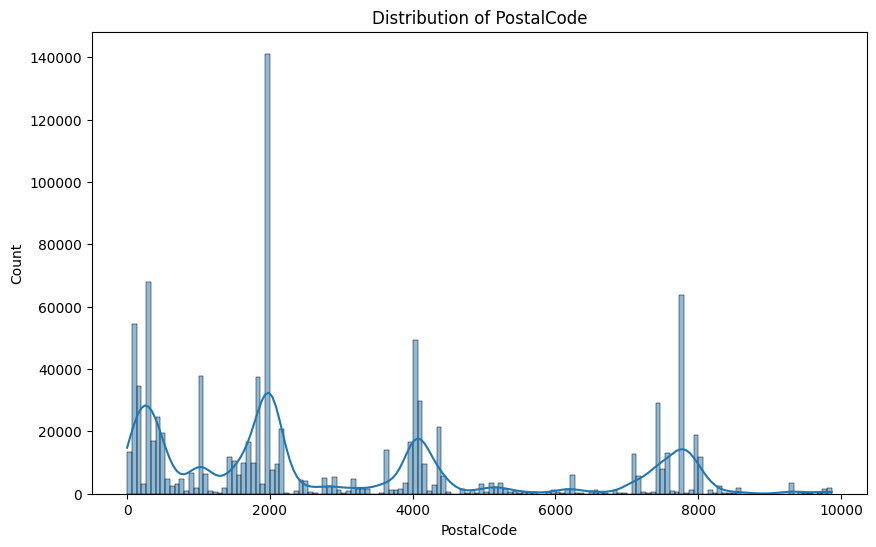

KeyboardInterrupt: 

In [46]:
def analyze_data(df):
    # Analyze the dataset
    print("Dataset shape:", df.shape)
    print("\nDataset info:")
    df.info()
    print("\nDataset description:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())

    # Visualize distributions of numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # for col in numeric_cols:
    #     plt.figure(figsize=(10, 6))
    #     sns.histplot(df[col], kde=True)
    #     plt.title(f'Distribution of {col}')
    #     plt.show()

    # Correlation matrix
    corr_matrix = df[numeric_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# Usage
analyze_data(data)  # Analyze the dataset before modeling

In [40]:
# Initialize StatisticalModeling
modeling = StatisticalModeling(data)

# Handle missing data and perform feature engineering
data = modeling.handle_missing_data()


e:\Studies\tenx\w3\src\statistical_modeling.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[col] = le.fit_transform(self.df[col].astype(str))
e:\Studies\tenx\w3\src\statistical_modeling.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[col] = le.fit_transform(self.df[col].astype(str))
e:\Studies\tenx\w3\src\statistical_modeling.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [41]:
# Function to plot feature importance
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(20))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Function to plot SHAP values
def plot_shap_values(shap_values, X_train, title):
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    plt.title(title)
    plt.tight_layout()
    plt.show()



2024-09-19 16:47:26,610 - INFO - Running analysis for target column: TotalClaims
2024-09-19 16:47:26,614 - INFO - Preparing data for target column: TotalClaims


Analyzing TotalClaims...


2024-09-19 16:47:27,412 - INFO - Selecting important features based on RandomForest feature importance
e:\Studies\tenx\w3\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
2024-09-19 16:49:09,056 - INFO - Selected important features: Index(['make', 'Model', 'SumInsured', 'RegistrationYear', 'ExcessSelected',
       'Province', 'MainCrestaZone', 'SubCrestaZone', 'Citizenship'],
      dtype='object')
2024-09-19 16:49:09,066 - INFO - Starting training for Linear Regression
2024-09-19 16:49:09,068 - INFO - Training model: LinearRegression
2024-09-19 16:49:09,661 - INFO - Model training complete: LinearRegression
2024-09-19 16:49:09,662 - INFO - Calculating feature importance for model: LinearRegression
2024-09-19 16:49:09,768 - INFO - Starting training for XGBoost
2024-09-19 16:49:09,773 - INFO - Training model: XGBRegressor
2024-09-19 16:49:16,344 - INFO - Model training complete: XGBRegresso

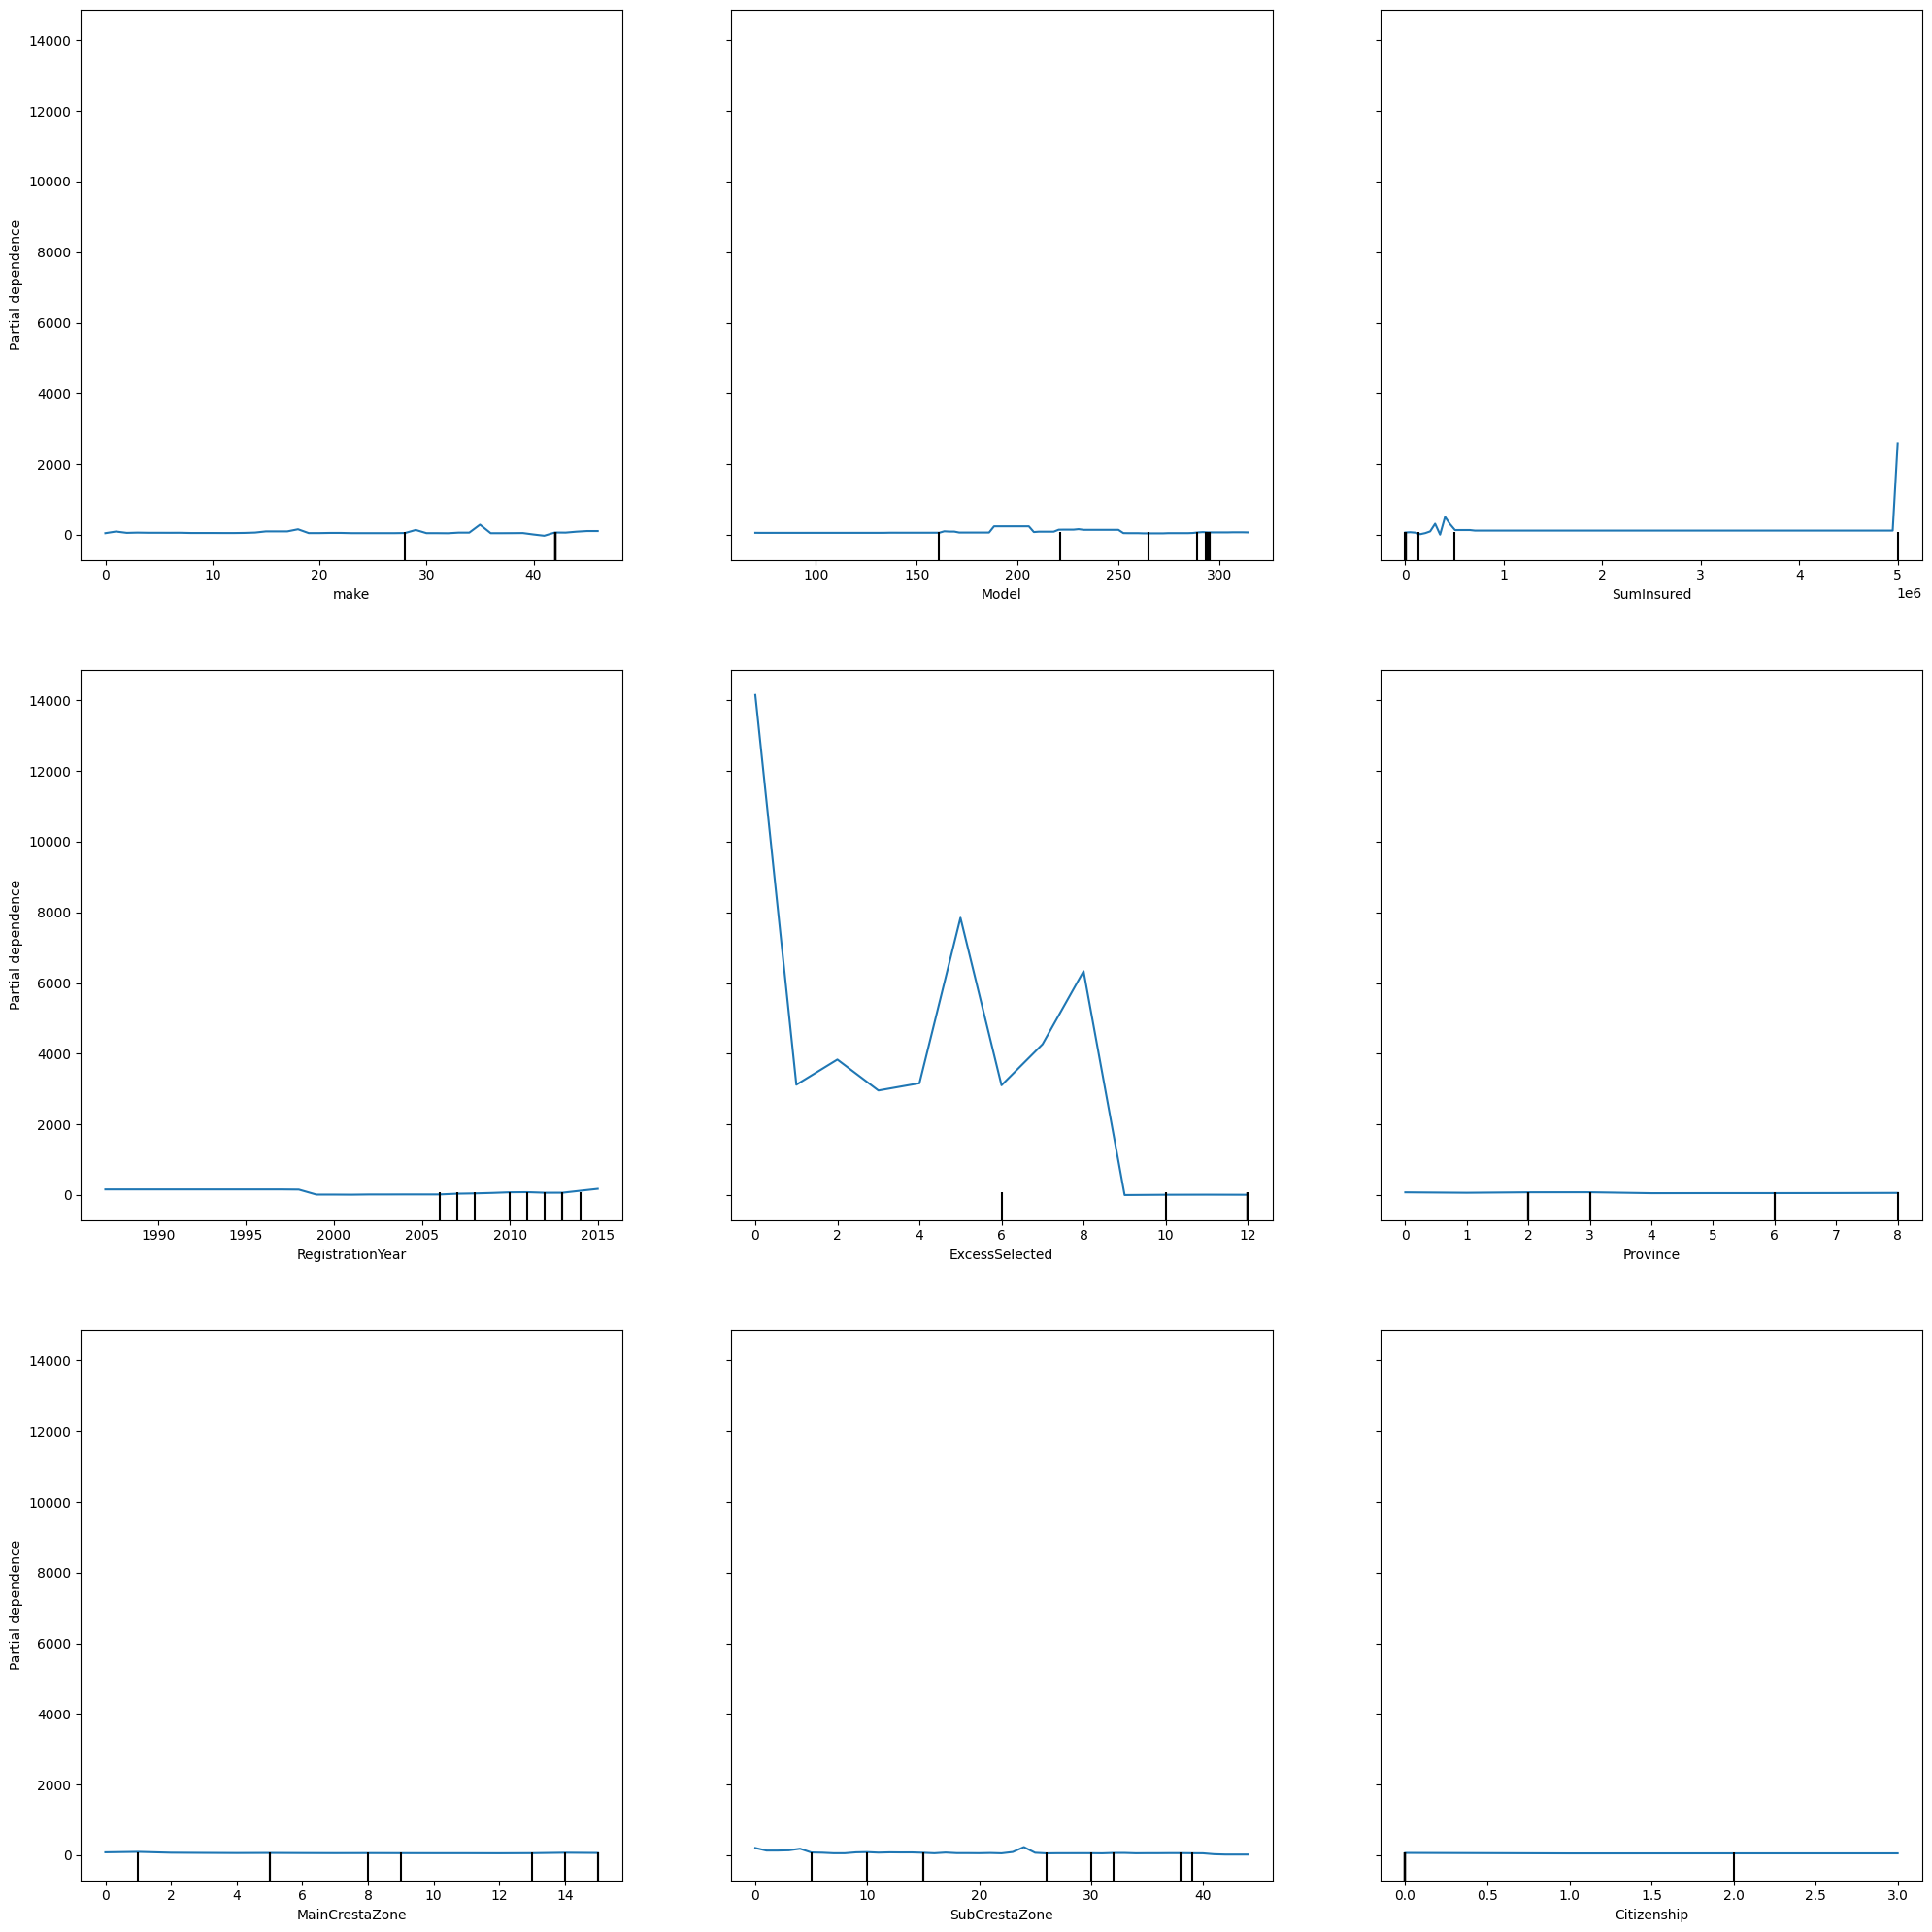

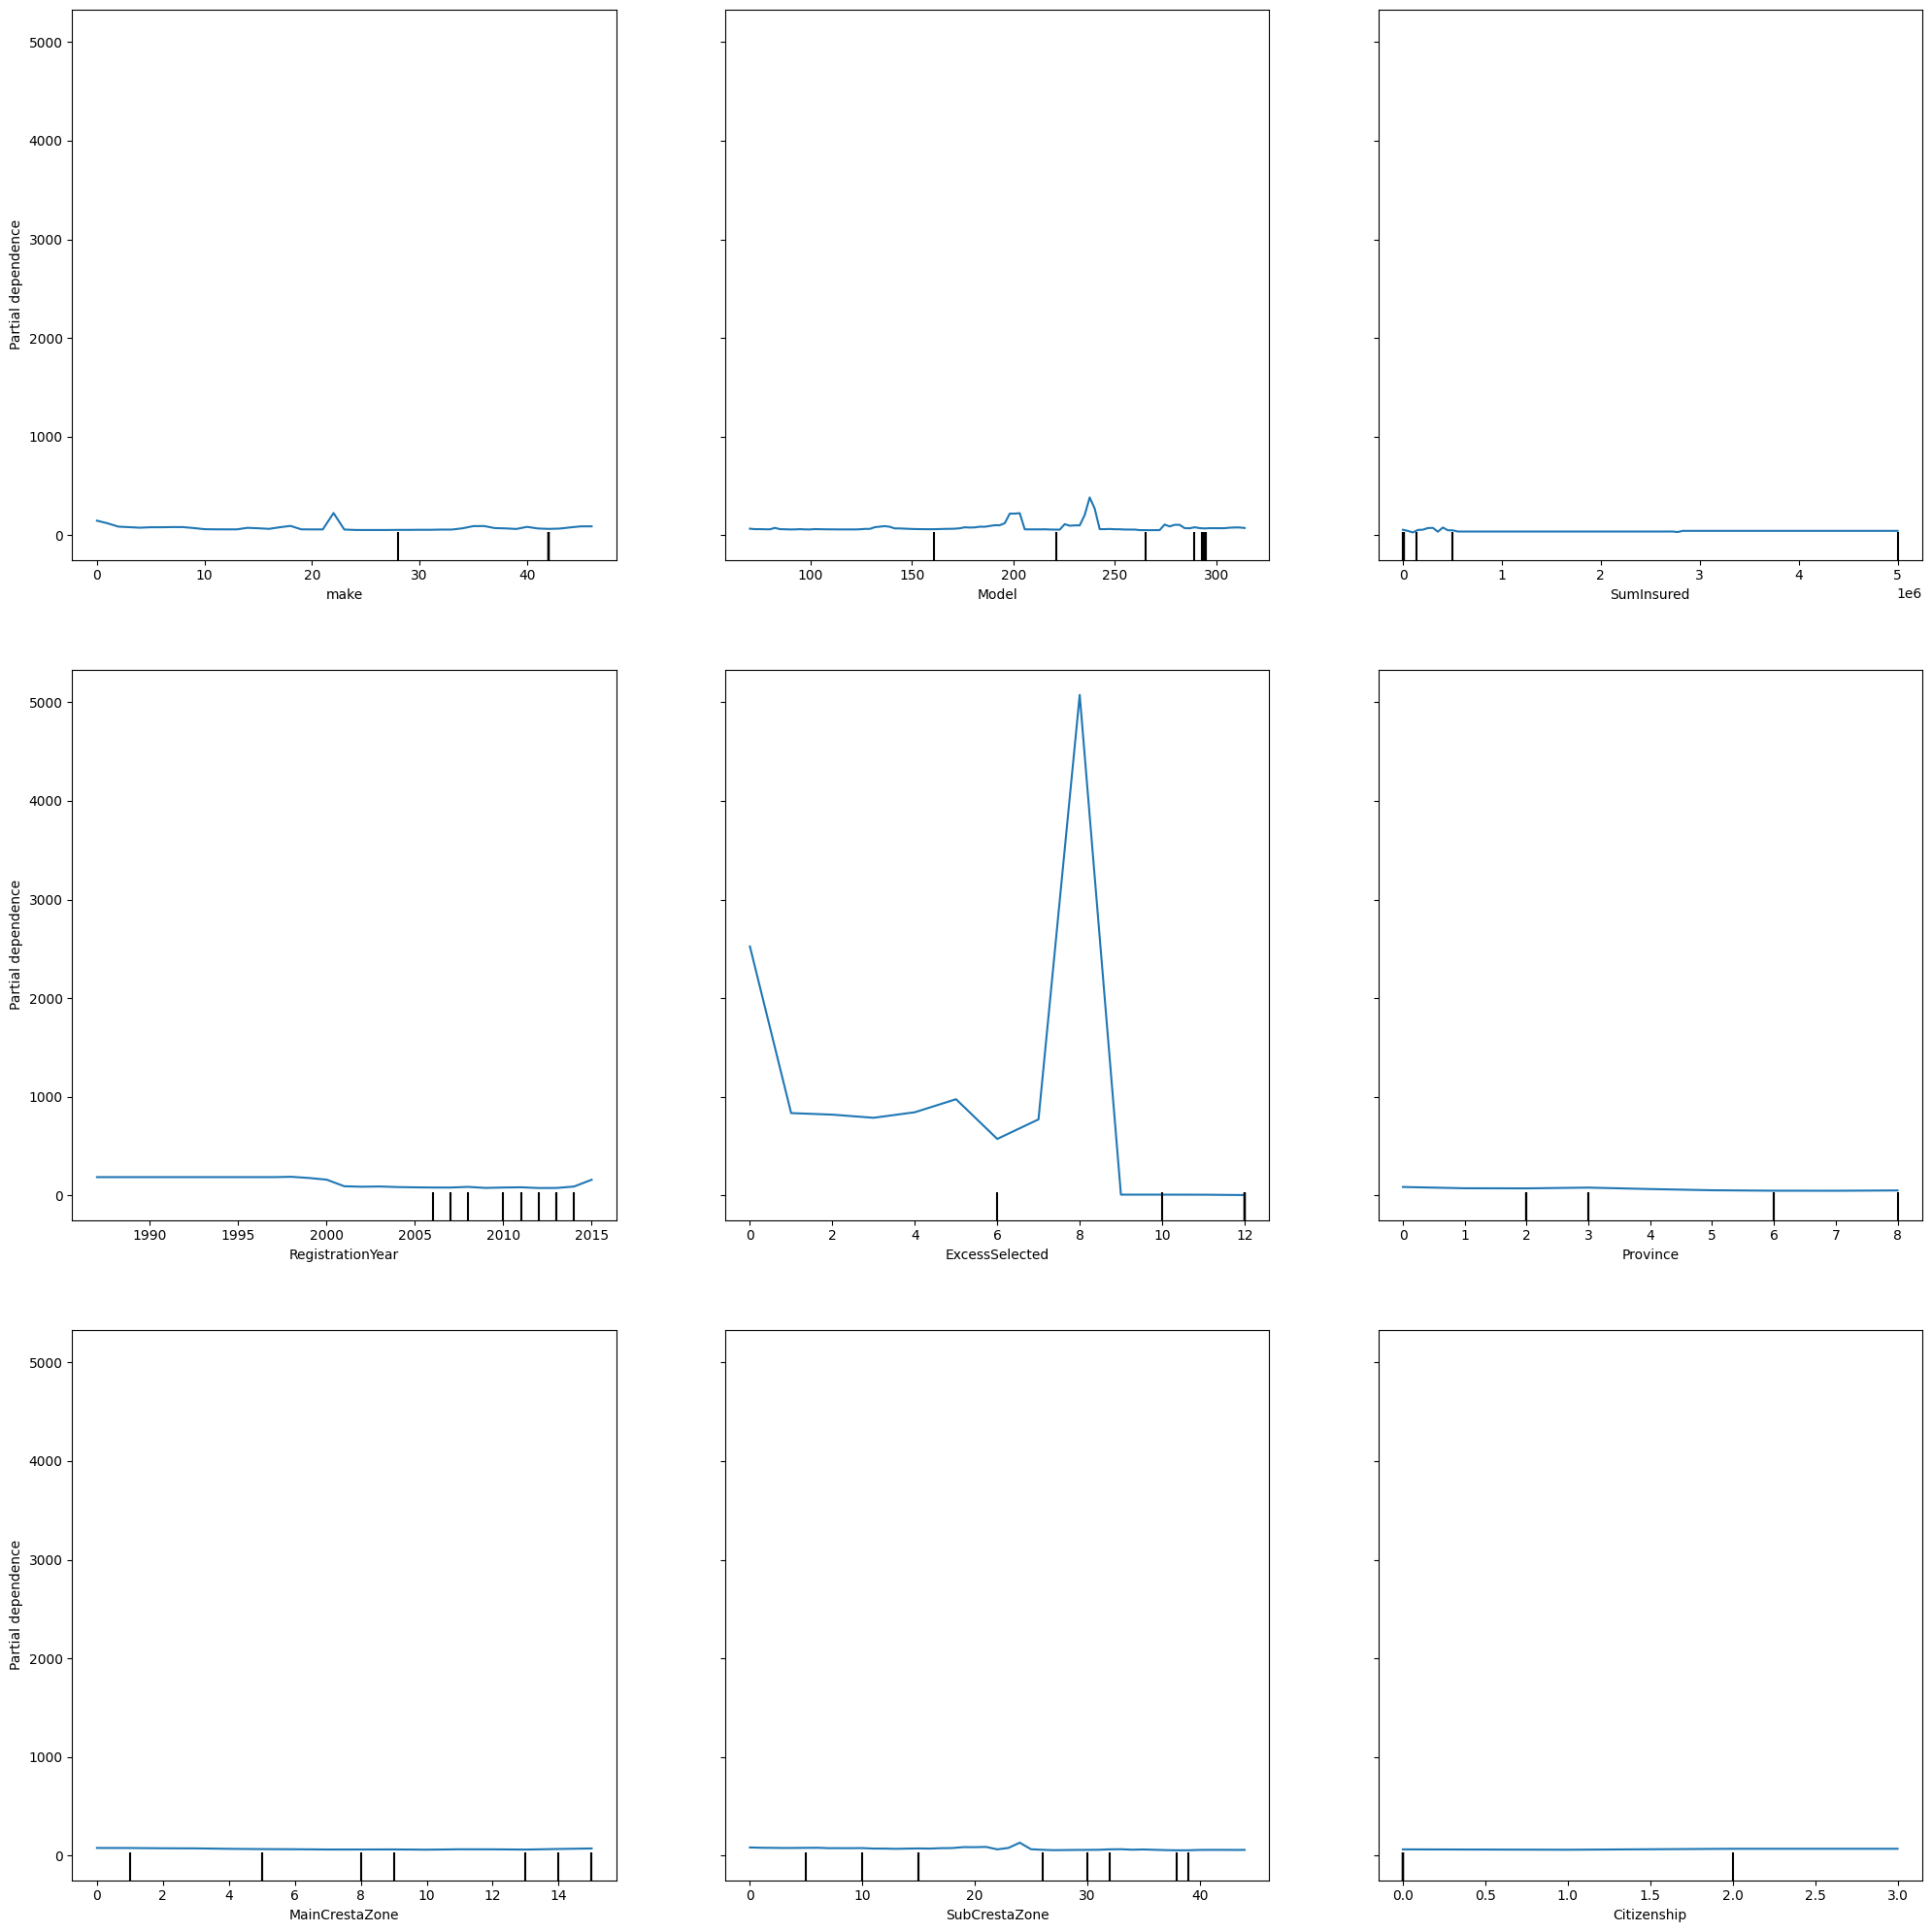

In [42]:
# Analyze TotalClaims
print("Analyzing TotalClaims...")
results_claims = modeling.run_analysis('TotalClaims')




Linear Regression Results:
MSE: 4861896.6112
R2 Score: 0.0050


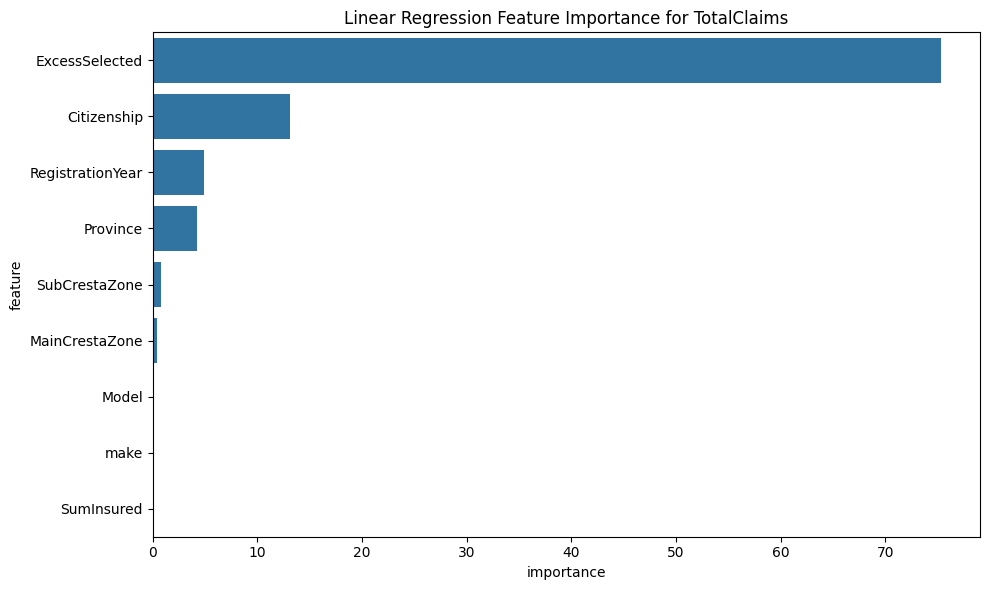


XGBoost Results:
MSE: 5279945.1629
R2 Score: -0.0805


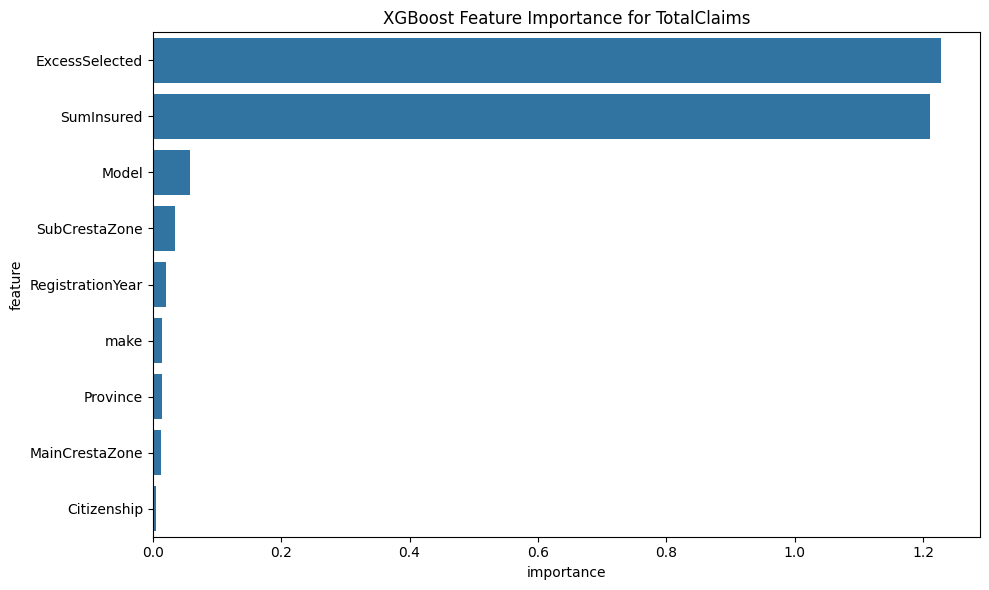


Random Forest Results:
MSE: 5672324.8093
R2 Score: -0.1608


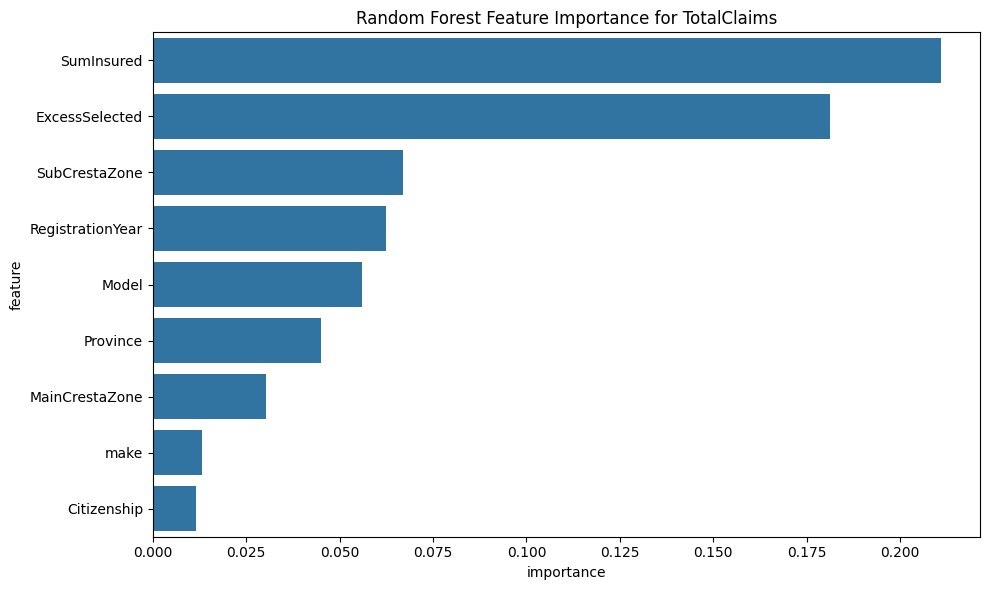

In [43]:
for model_name, result in results_claims.items():
    print(f"\n{model_name} Results:")
    print(f"MSE: {result['mse']:.4f}")
    print(f"R2 Score: {result['r2']:.4f}")
    
    plot_feature_importance(result['feature_importance'], f"{model_name} Feature Importance for TotalClaims")
    
    if 'shap_values' in result:
        plot_shap_values(result['shap_values'], result['model'].X_train, f"{model_name} SHAP Values for TotalClaims")

In [44]:
# Analyze TotalPremium
print("\nAnalyzing TotalPremium...")
results_premium = modeling.run_analysis('TotalPremium')

for model_name, result in results_premium.items():
    print(f"\n{model_name} Results:")
    print(f"MSE: {result['mse']:.4f}")
    print(f"R2 Score: {result['r2']:.4f}")
    
    plot_feature_importance(result['feature_importance'], f"{model_name} Feature Importance for TotalPremium")
    
    if 'shap_values' in result:
        plot_shap_values(result['shap_values'], result['model'].X_train, f"{model_name} SHAP Values for TotalPremium")



2024-09-19 17:06:52,982 - INFO - Running analysis for target column: TotalPremium
2024-09-19 17:06:52,985 - INFO - Preparing data for target column: TotalPremium



Analyzing TotalPremium...


2024-09-19 17:06:53,432 - INFO - Selecting important features based on RandomForest feature importance
e:\Studies\tenx\w3\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
2024-09-19 17:09:47,984 - INFO - Selected important features: Index(['Model', 'SumInsured', 'RegistrationYear', 'ExcessSelected',
       'MainCrestaZone', 'CapitalOutstanding', 'CustomValueEstimate',
       'CalculatedPremiumPerTerm'],
      dtype='object')
2024-09-19 17:09:48,064 - INFO - Starting training for Linear Regression
2024-09-19 17:09:48,065 - INFO - Training model: LinearRegression


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Compare model performance
def compare_models(results_claims, results_premium):
    models = list(results_claims.keys())
    mse_claims = [results_claims[model]['mse'] for model in models]
    r2_claims = [results_claims[model]['r2'] for model in models]
    mse_premium = [results_premium[model]['mse'] for model in models]
    r2_premium = [results_premium[model]['r2'] for model in models]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, mse_claims, width, label='TotalClaims')
    ax1.bar(x + width/2, mse_premium, width, label='TotalPremium')
    ax1.set_ylabel('Mean Squared Error')
    ax1.set_title('MSE Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()

    ax2.bar(x - width/2, r2_claims, width, label='TotalClaims')
    ax2.bar(x + width/2, r2_premium, width, label='TotalPremium')
    ax2.set_ylabel('R2 Score')
    ax2.set_title('R2 Score Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()

    plt.tight_layout()
    plt.show()

compare_models(results_claims, results_premium)

# Print final conclusions
print("\nFinal Conclusions:")
best_model_claims = max(results_claims, key=lambda x: results_claims[x]['r2'])
best_model_premium = max(results_premium, key=lambda x: results_premium[x]['r2'])

print(f"Best model for TotalClaims: {best_model_claims}")
print(f"Best model for TotalPremium: {best_model_premium}")

print("\nTop 5 features for TotalClaims:")
print(results_claims[best_model_claims]['feature_importance'].head())

print("\nTop 5 features for TotalPremium:")
print(results_premium[best_model_premium]['feature_importance'].head())